In [13]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

red = pd.read_csv("winequality-red.csv", sep=";")
oldnames = red.columns
rename_dict = {old: old.replace(" ", "_") for old in oldnames}
red = red.rename(rename_dict, axis=1)

white = pd.read_csv("winequality-white.csv", sep=";")
oldnames = white.columns
rename_dict = {old: old.replace(" ", "_") for old in oldnames}
white = white.rename(rename_dict, axis=1)

frame = pd.concat([red, white], ignore_index=True)
print (len(red), len(white), len(frame))
frame.head()

1599 4898 6497


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [2]:
import pandas as pd
to_be_discretized = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
columns = []
for column in frame.columns:
    col = frame[column]
    if column in to_be_discretized:
        col = pd.cut(col, 5, labels = range(5))
        
    col = pd.get_dummies(col, prefix = column)
    columns.append(col)
frame = pd.concat(columns, axis=1)
train, test = train_test_split(frame, random_state = 0)
print (len(frame), len(train), len(test))

6497 4872 1625


In [3]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules

frequent_itemsets = fpgrowth(train, use_colnames=True, min_support = 0.5)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold = 0.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(chlorides_0),(free_sulfur_dioxide_0),0.975575,0.932882,0.912151,0.934988,1.002258,0.002055,1.032404
1,(free_sulfur_dioxide_0),(chlorides_0),0.932882,0.975575,0.912151,0.977778,1.002258,0.002055,1.099138
2,(volatile_acidity_0),(chlorides_0),0.719417,0.975575,0.707718,0.983738,1.008367,0.005872,1.501941
3,(chlorides_0),(volatile_acidity_0),0.975575,0.719417,0.707718,0.725437,1.008367,0.005872,1.021924
4,(volatile_acidity_0),(free_sulfur_dioxide_0),0.719417,0.932882,0.660099,0.917546,0.983561,-0.011033,0.814012
...,...,...,...,...,...,...,...,...,...
333,(chlorides_0),"(residual_sugar_0, free_sulfur_dioxide_0, dens...",0.975575,0.755337,0.740764,0.759310,1.005260,0.003876,1.016508
334,(residual_sugar_0),"(free_sulfur_dioxide_0, density_0, chlorides_0)",0.921182,0.749179,0.740764,0.804144,1.073368,0.050633,1.280642
335,(density_0),"(free_sulfur_dioxide_0, residual_sugar_0, chlo...",0.811782,0.843186,0.740764,0.912516,1.082224,0.056281,1.792489
336,(free_sulfur_dioxide_0),"(residual_sugar_0, chlorides_0, density_0)",0.932882,0.785099,0.740764,0.794059,1.011414,0.008359,1.043512


In [4]:
import numpy as np

confidences = []
for i, row in rules.iterrows():
    acondition = None
    for name in row.antecedents:
        if acondition is None:
            acondition = (test[name] == 1)
        else:
            acondition = acondition & (test[name] == 1)
    
    ccondition = None
    for name in row.consequents:
        if ccondition is None:
            ccondition = (test[name] == 1)
        else:
            ccondition = ccondition & (test[name] == 1)
    
    confidences.append (len(test[acondition & ccondition]) / len(test[acondition]))

print ("test condidence = %.2f, alen = %.2f, clen = %.2f" % (np.mean(confidences), 
                                                            rules.antecedents.apply(len).mean(), 
                                                            rules.consequents.apply(len).mean()))

test condidence = 0.86, alen = 1.99, clen = 1.56


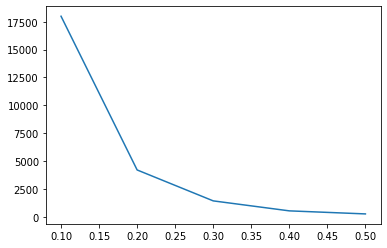

In [13]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules
ms = [0.1, 0.2, 0.3, 0.4, 0.5]
lr = []
for s in ms:
    frequent_itemsets = fpgrowth(frame, use_colnames=True, min_support = s)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold = 0.8)
    lr.append(len(rules))
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(ms, lr)

In [41]:
train = frame.to_numpy().astype(float)
features = frame.columns.tolist()

In [42]:
from spn.algorithms.Inference import log_likelihood
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.Base import Context
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian, Bernoulli

ptypes = [Gaussian] * len(features)
#ptypes[-1] = Bernoulli
categorical = [False] * len(features)
#categorical[-1] = True

In [43]:
import warnings
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.Base import Context


net = learn_parametric(train, 
                       ds_context = Context(parametric_types=ptypes).add_domains(train), 
                       rows = "gmm",
                       min_instances_slice = len(train)/100)

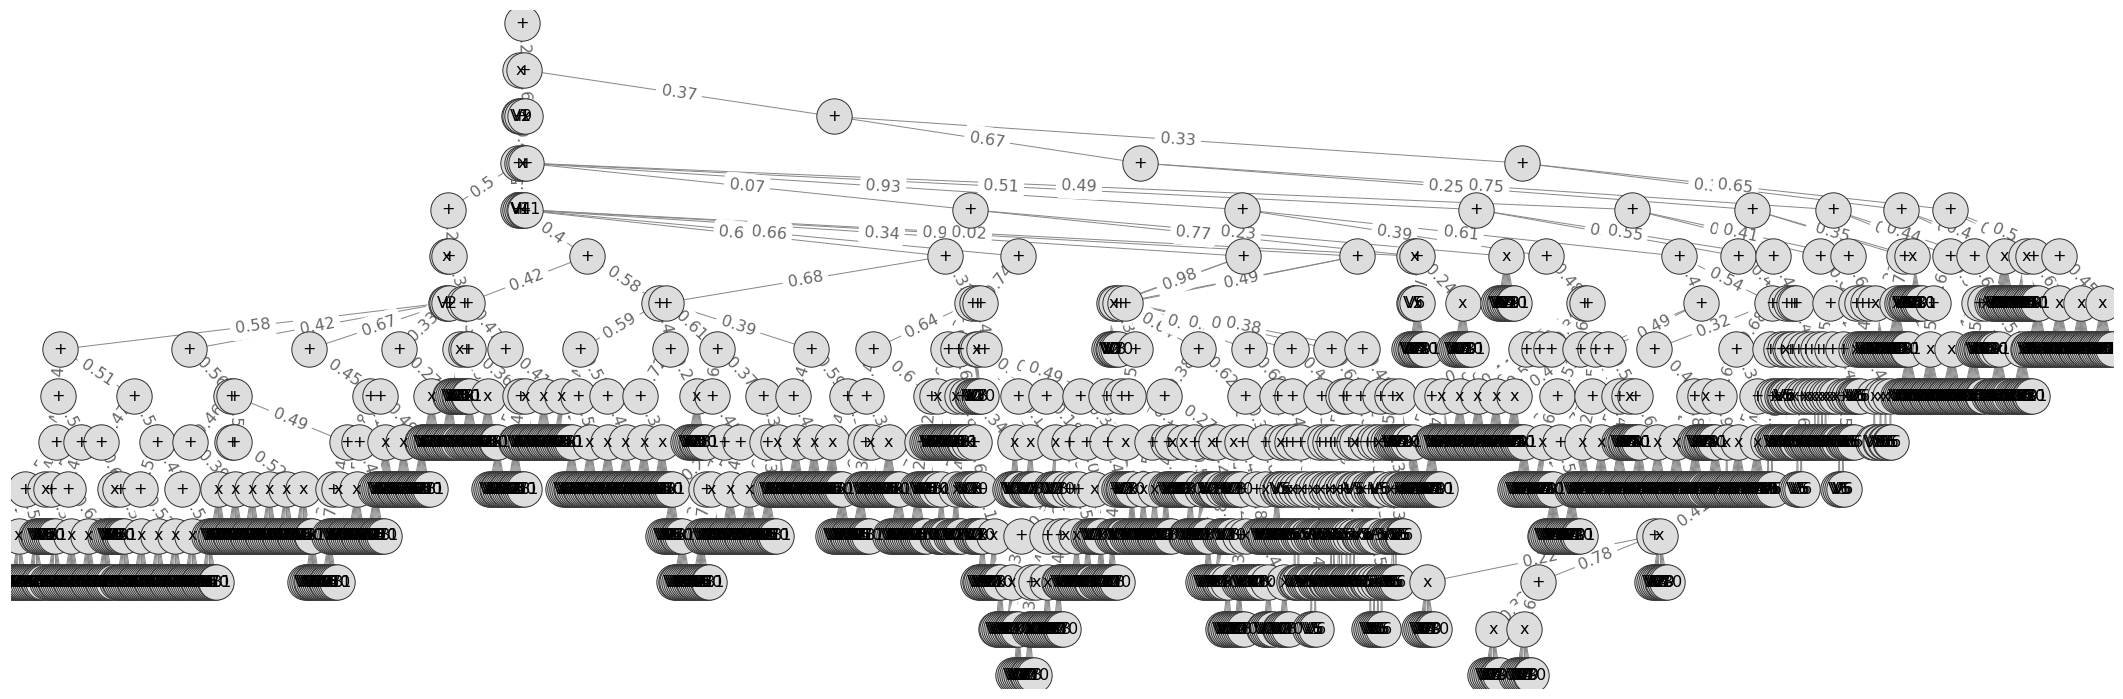

In [44]:
from spn.io.Graphics import plot_spn
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30, 10))
plot_spn(net)

In [45]:
import csi 
import importlib 
importlib.reload(csi)

<module 'csi' from '/home/saurabh/Documents/Projects/QC/SPFlow/src/csi.py'>

In [49]:
def format_clause(clause):
    parts = []
    for subclause in clause.split(" and "):
        # print (repr(subclause))
        try:
            a, sign, b = subclause.split(" ")
        except ValueError as e:
            print (e)
            return "NAN"
        # i = names.index(a)
        v = b #value_text[i][int(b)]
        if ('==' in sign) or ('!=' in sign):
            b = str(int(b))
            if ((sign, b) == ('==', '1')) or ((sign, b) == ('!=', '0')):
                parts.append("%s" % (a))
            else:
                parts.append("~%s" % (a))
        else:
            parts.append("(%s %s %.4f)" % (a, sign, float(b)))
    return " & ".join(parts)
def format_rule(rule):
    antecedent, consequent, score, support = rule
    
    anodes = [' | '.join(["(%s)"% format_clause(clause) for clause in node]) for node in antecedent]
    antecedent = ' & '.join([node if node.startswith("(") else "(%s)" % node for node in anodes])
    cnodes = ["(%s)" % ",".join(node) for node in consequent]
    consequent = ", ".join(cnodes)
    return antecedent, consequent, round(score, 4), min(support, len(D))

In [50]:
categorical = [False] * len(features)
# categorical[-1] = True
D = train
csi.annotate(net, features, categorical, min_impurity_decrease=0.1, min_instances_slice = len(D)/20)
for rule in csi.context_specific_independences(net):
    rule = format_rule(rule)
    print ("{%s} => {%s} (%.2f, %d)" % rule, end="\n\n")

{((chlorides <= 0.0585))} => {(fixed_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,alcohol,quality), (volatile_acidity), (sulphates)} (0.94, 4588)

{((chlorides > 0.0585)) & ((total_sulfur_dioxide <= 72.5000))} => {(fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,density,pH,sulphates,alcohol,quality), (free_sulfur_dioxide,total_sulfur_dioxide)} (0.84, 1206)

{((chlorides <= 0.0585)) & ((density > 0.9948))} => {(fixed_acidity,citric_acid,residual_sugar,density,pH,alcohol), (chlorides), (free_sulfur_dioxide,total_sulfur_dioxide), (quality)} (0.78, 1837)

{((chlorides <= 0.0585)) & ((density <= 0.9948)) & ((residual_sugar > 2.4500)) & ((citric_acid <= 0.3850))} => {(fixed_acidity,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,alcohol,quality), (citric_acid)} (0.80, 1026)



In [51]:
csi.annotate(net, features, categorical, min_impurity_decrease=0.1, min_instances_slice = len(train)/20)
rows = []
for rule in csi.context_specific_independences(net):
    rule = format_rule(rule)
    t = ("$%s$ \t %s \t %.2f \t %d" % rule)
    t = t.replace("&", "\land").replace("|", "\lor")
    t = t.replace("==", "=").replace("!=", "\\neq")
    t = t.replace("<=", "\leq")
    t = t.replace("-", "\_")
    rows.append (t.split("\t"))
pd.DataFrame(rows, columns = ['Antecedent', 'Consequent', 'Score', 'Support']).to_csv("winequality_csi.csv", index=False)

(0, 0.5)

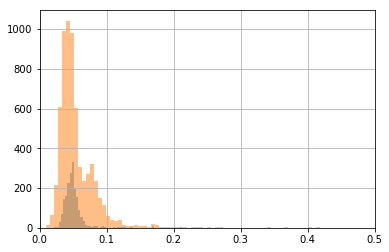

In [41]:
frame[((frame.density > 0.9948049783706665) & (frame.red == False))].chlorides.hist(bins=100, alpha=0.5, label = 'ss')
frame.chlorides.hist(label = 'all', bins=100, alpha=0.5)
plt.xlim(0, 0.5)

/home/saurabh/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


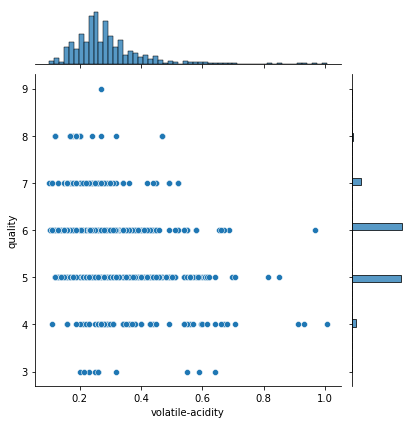

In [43]:
f1 = frame[((frame.density > 0.9948049783706665) & (frame.red == False))]
import seaborn as sns
sns.jointplot(f1['volatile-acidity'], f1['quality'])

In [44]:
len(f1)

1880